In [1]:
%run InitAndFuctions.ipynb

Host: c2391c0ea7fc
3.6.8 (default, Nov 16 2020, 16:55:22) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)] <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f3f498fe5f8>
Welcome to JupyROOT 6.22/06


In [2]:
#!ls ../out/cosmics_run4039_cmin_0_cmax_10_rescale_576_nsigma_0.5_ev_200_ped_4038_ms*

# analisi

In [3]:
file_out=mybasepath+"out/cosmics_run4035_cmin_0_cmax_10_rescale_576_nsigma_0.5_ev_100_ped_4034.plk.gz"
file_out=mybasepath+"out/cosmics_run4045_cmin_0_cmax_10_rescale_576_nsigma_0.5_ev_200_ped_4038_ms_2_rt_3_vL.1.plk.gz"
df = pd.read_pickle(file_out, compression='gzip')
fileInfo = FileNameInfo(file_out)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.


In [4]:
fileInfo

,cosmics,cmin,cmax,rescale,nsigma,ev,ped,ms,rt,version
0,run4045,0,10,576,0.5,200,4038,2,3,vL.1.plk.gz


In [5]:
run_info_logbook(int(fileInfo.cosmics[0].split('run')[-1]), verbose=False)

File_Number                                        4045
saved_events                                        200
Exposure_Time_ms                                      1
comments                          55Fe - Z = 36-1=35 cm
Nominal_Flux_He_CF4                               60/40
He_CF4                                              NaN
Transfer_field_kV_cm                                2.5
GEM3_V                                              430
GEM2_V                                              440
GEM1_V                                              440
Calculated_GEM_stack_V                             1315
Requested_Drift_field_V_cm                          960
Calculated_Field_Cage_Anode_V                     316.8
Real_Field_Cage_Anode_V                             317
Calculated_Field_Cage_Catode_V                    49632
Calculated_Drift_Field_V_cm                     960.004
Name: 2967, dtype: object

In [6]:
df

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,length,mse,r2,x0c,y0c
0,0.0,0.0,10320.0,34390.060,3.332370,1824.0,172.0,520.0,2140.0,2360.813419,2.835263,0.999412,1172.0,1156.0
1,0.0,1.0,9344.0,31549.530,3.376448,1720.0,164.0,312.0,2148.0,2432.841960,4.128789,0.999354,1016.0,1156.0
2,0.0,2.0,8272.0,27659.900,3.343798,2136.0,844.0,1528.0,2152.0,1442.403550,2.576530,0.998639,1832.0,1498.0
3,0.0,3.0,7312.0,20876.940,2.855161,2144.0,192.0,556.0,2152.0,2522.566947,3.943761,0.999497,1350.0,1172.0
4,0.0,4.0,5488.0,17212.500,3.136388,1372.0,164.0,1896.0,2108.0,2013.383222,2.581665,0.997055,1634.0,1136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,199.0,15.0,3200.0,8894.025,2.779383,2148.0,316.0,156.0,2140.0,2700.933172,6.462773,0.999678,1152.0,1228.0
3996,199.0,16.0,2960.0,8978.515,3.033282,756.0,188.0,2132.0,1872.0,2174.679747,4.399439,0.999575,1444.0,1030.0
3997,199.0,17.0,2976.0,8181.675,2.749219,1488.0,160.0,240.0,2140.0,2340.492256,3.989997,0.999591,864.0,1150.0
3998,199.0,18.0,3088.0,8945.370,2.896817,1628.0,156.0,1516.0,2136.0,1983.165147,2.321863,0.974509,1572.0,1146.0


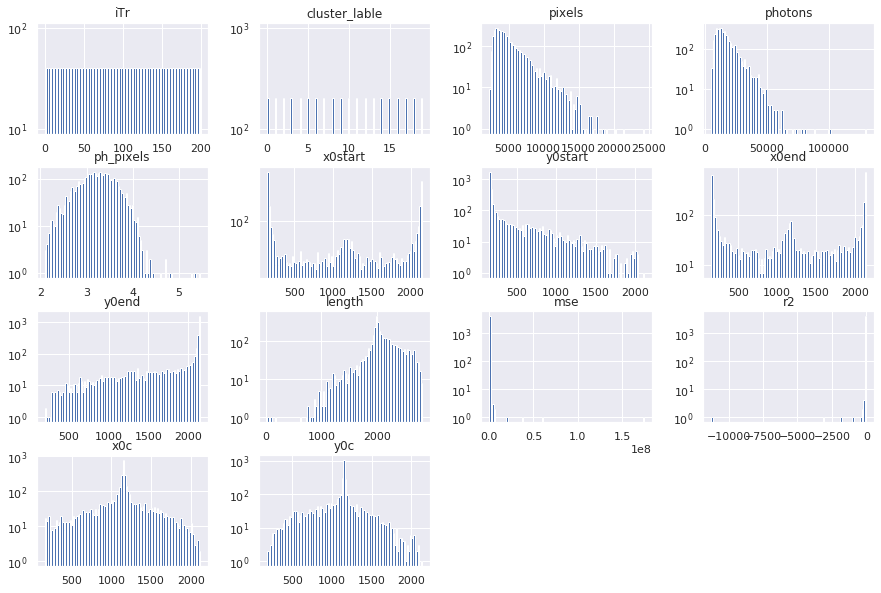

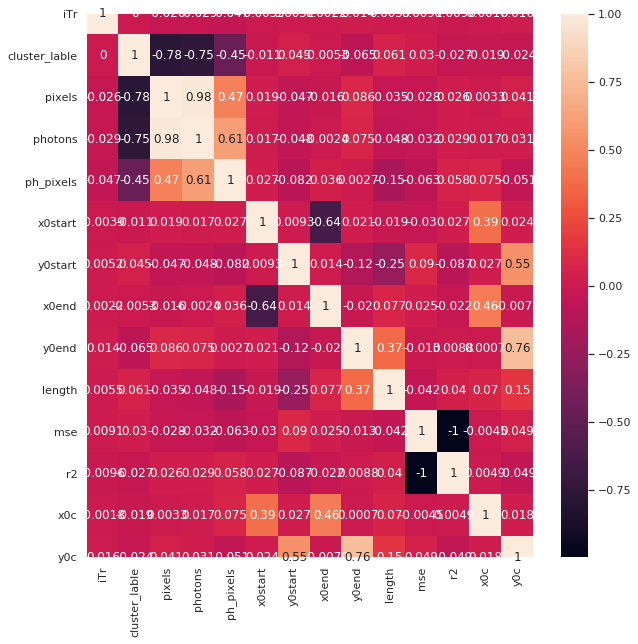

In [7]:
import seaborn as sns
sns.set()
#
# Visulizza tutte le Varibili
#
df.hist(bins=100, figsize=(15,10), log=True)
plt.show()

plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

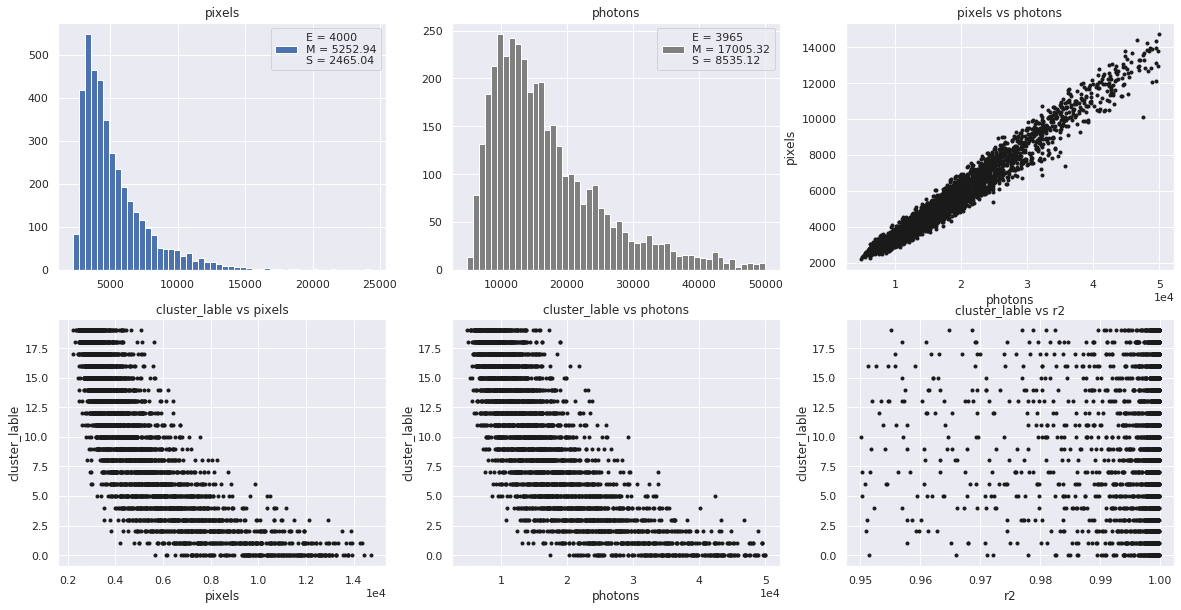

In [8]:
fig, ax = plt.subplots(2,3, figsize=(20,10))
pd_his_plot(df.pixels, ax=ax[0, 0], bins=50)
phmax=50000
pd_his_plot(df.photons[(df.photons<phmax)], ax=ax[0, 1], bins=50, color="gray")
ax[0, 2].set_title('pixels vs photons')
ax[0, 2].plot(df.photons[df.photons<phmax].values, df.pixels[df.photons<phmax].values, 'k.')
ax[0, 2].set_xlabel('photons')
ax[0, 2].set_ylabel('pixels')
ax[0, 2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax[1, 0].set_title('cluster_lable vs pixels')
ax[1, 0].plot(df.pixels[df.photons<phmax].values, df.cluster_lable[df.photons<phmax].values, 'k.')
ax[1, 0].set_xlabel('pixels')
ax[1, 0].set_ylabel('cluster_lable')
ax[1, 0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax[1, 1].set_title('cluster_lable vs photons')
ax[1, 1].plot(df.photons[df.photons<phmax].values, df.cluster_lable[df.photons<phmax].values, 'k.')
ax[1, 1].set_xlabel('photons')
ax[1, 1].set_ylabel('cluster_lable')
ax[1, 1].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax[1, 2].set_title('cluster_lable vs r2')
ax[1, 2].plot(df.r2[df.r2>0.95].values, df.cluster_lable[df.r2>0.95].values, 'k.')
ax[1, 2].set_xlabel('r2')
ax[1, 2].set_ylabel('cluster_lable')
ax[1, 2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))

#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
plt.show()

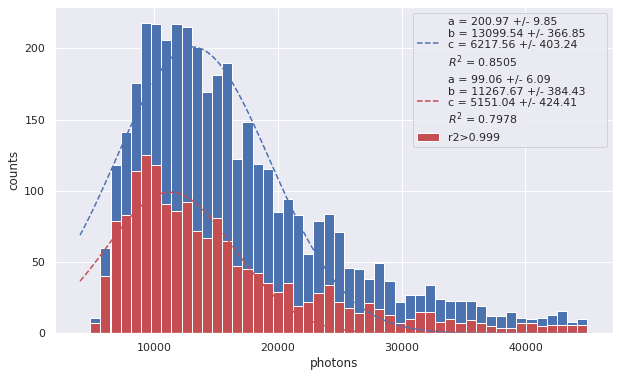

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
histGaus(df.photons, 50, ax, color='b', xrange=(4000,45000), alpha=1, label='')
histGaus(df.photons[df.r2>0.999], 50, ax, color='r', xrange=(4000,45000), alpha=1, label='r2>0.999')
plt.xlabel('photons')
plt.ylabel('counts')
plt.legend()
plt.show()

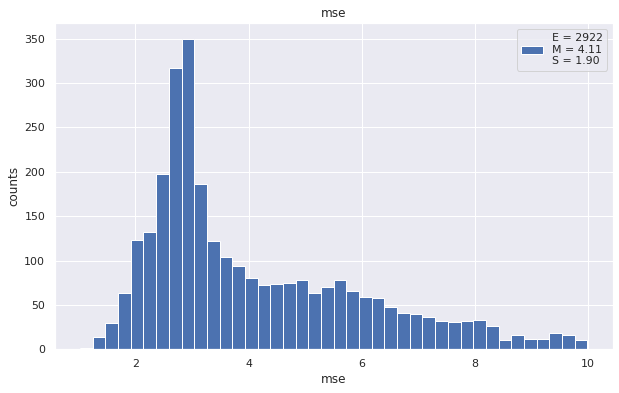

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
pd_his_plot(df.mse[(df.mse>0) & (df.mse<10) ], ax=ax, bins=40)
#histGaus(df.mse, 40, ax, color='b', xrange=(0.,10), alpha=1, label='')
plt.xlabel('mse')
plt.ylabel('counts')
plt.legend()
plt.show()

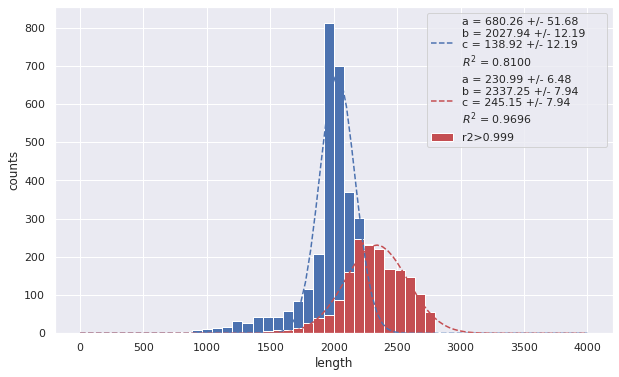

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
histGaus(df.length, 50, ax, color='b', xrange=(0,4000), alpha=1, label='')
histGaus(df.length[df.r2>0.999], 50, ax, color='r', xrange=(0,4000), alpha=1, label='r2>0.999')
plt.xlabel('length')
plt.ylabel('counts')
plt.legend()
plt.show()

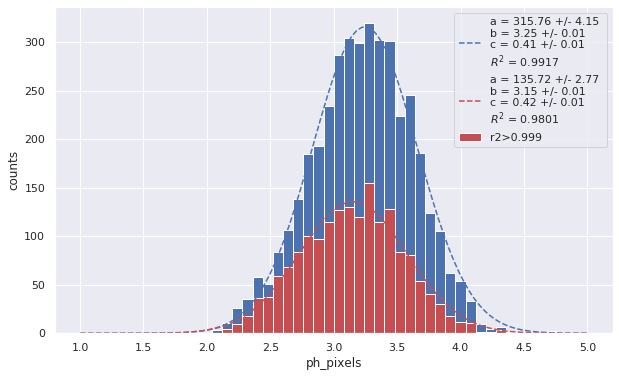

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
histGaus(df.ph_pixels, 50, ax, color='b', xrange=(1,5), alpha=1, label='')
histGaus(df.ph_pixels[df.r2>0.999], 50, ax, color='r', xrange=(1,5), alpha=1, label='r2>0.999')
plt.xlabel('ph_pixels')
plt.ylabel('counts')
plt.legend()
plt.show()

No handles with labels found to put in legend.


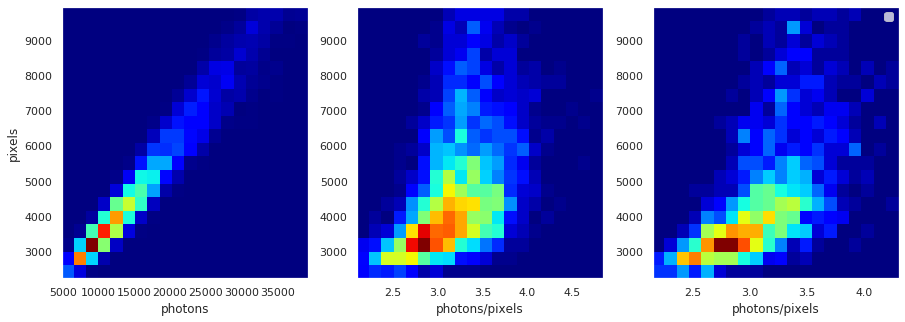

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
mpixe = 10000
mph   = 50000
mpphp_p = 10
ax[0].hist2d(df.photons.values[((df.pixels<mpixe)&(df.photons<mph))], 
           df.pixels.values[((df.pixels<mpixe)&(df.photons<mph))], 
           bins=(20,20), cmap=plt.cm.jet)
ax[0].set_xlabel("photons")
ax[0].set_ylabel("pixels")
ax[1].hist2d(df.ph_pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p))], 
           df.pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p))], 
           bins=(20,20), cmap=plt.cm.jet)
ax[1].set_xlabel("photons/pixels")
ax[2].hist2d(df.ph_pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p)&(df.r2>0.999))], 
           df.pixels.values[((df.pixels<mpixe)&(df.ph_pixels<mpphp_p)&(df.r2>0.999))], 
           bins=(20,20), cmap=plt.cm.jet, label='r2>0.999')
ax[2].set_xlabel("photons/pixels")
ax[2].legend()
plt.show()

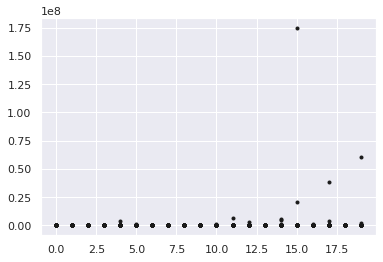

In [14]:
plt.plot(df.cluster_lable.values, df.mse.values, 'k.')
plt.show()

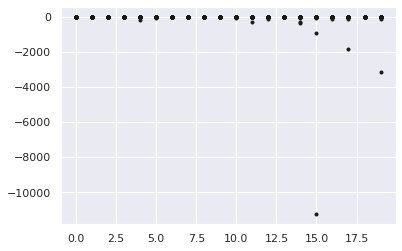

In [15]:
plt.plot(df.cluster_lable.values, df.r2.values, 'k.')
plt.show()

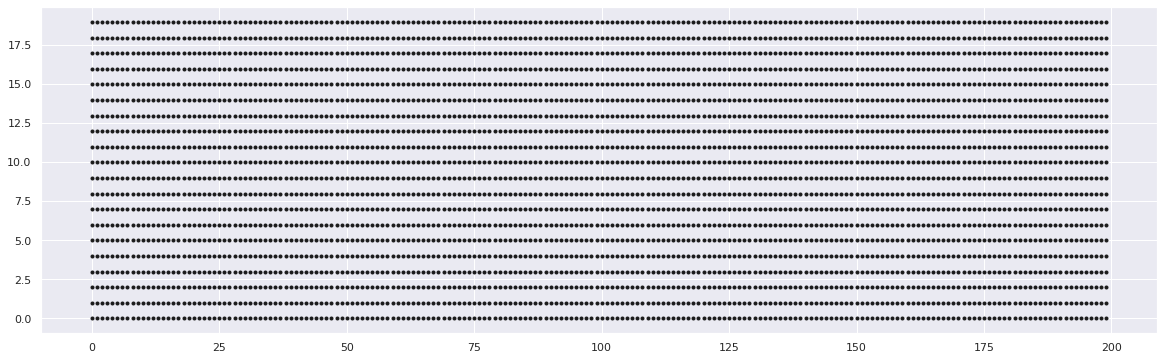

In [16]:
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(df.iTr.values, df.cluster_lable.values, 'k.')
plt.show()

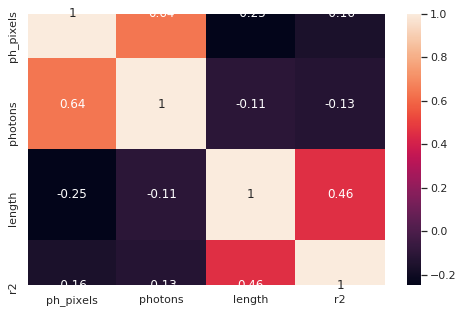

,ph_pixels,photons,length,r2
ph_pixels,1.000000,0.641359,-0.249964,-0.161964
photons,0.641359,1.000000,-0.108058,-0.125836
length,-0.249964,-0.108058,1.000000,0.455673
r2,-0.161964,-0.125836,0.455673,1.000000


In [17]:
import seaborn as sns
# pixels	photons	ph_pixels	x0start	y0start	x0end	y0end	length	mse	r2
features = df[['ph_pixels', 'photons', 'length', 'r2']][(df.r2>0.99)].copy()
plt.figure(figsize = (8,5))
sns.heatmap(features.corr(), annot=True)
plt.show()

features.corr()

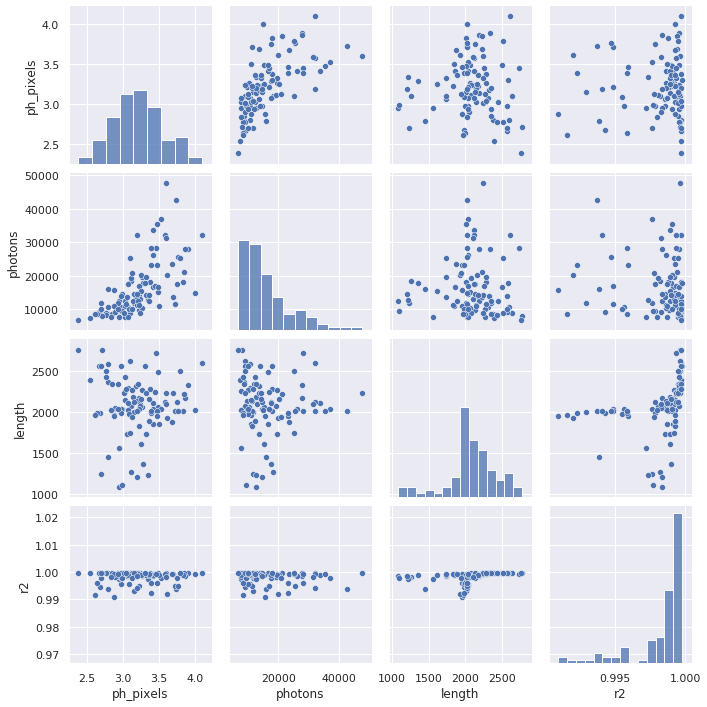

In [18]:
sns.pairplot(features.sample(100))
plt.show()

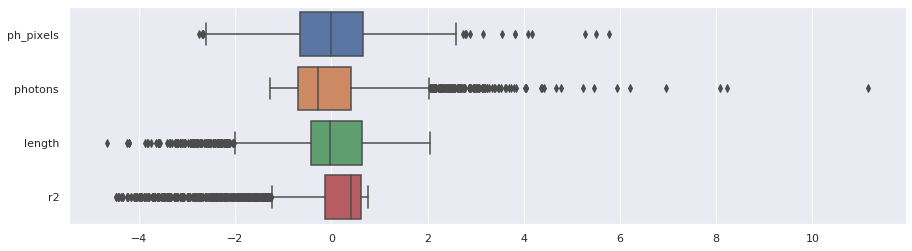

,ph_pixels,photons,length,r2
count,3.053000e+03,3.053000e+03,3.053000e+03,3.053000e+03
mean,-8.378493e-17,-2.560095e-16,-1.943345e-16,5.118270e-14
std,1.000164e+00,1.000164e+00,1.000164e+00,1.000164e+00
min,-2.745190e+00,-1.274728e+00,-4.671703e+00,-4.477887e+00
25%,-6.518166e-01,-6.916718e-01,-4.137926e-01,-1.320432e-01
50%,1.796918e-03,-2.732607e-01,-3.246923e-02,4.150536e-01
75%,6.513656e-01,4.011889e-01,6.451574e-01,6.085212e-01
max,5.769210e+00,1.114550e+01,2.052073e+00,7.527011e-01


In [19]:
# normalizzazione delle variabili

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
# pixels	photons	ph_pixels	x0start	y0start	x0end	y0end	length	mse	r2
scaled_dataframe = pd.DataFrame( scaled_array, columns = features.columns ) # df.colums per tutte e colonne
plt.figure(figsize = (15,4))
sns.boxplot(data = scaled_dataframe, orient = "h")
plt.show()
scaled_dataframe.describe()

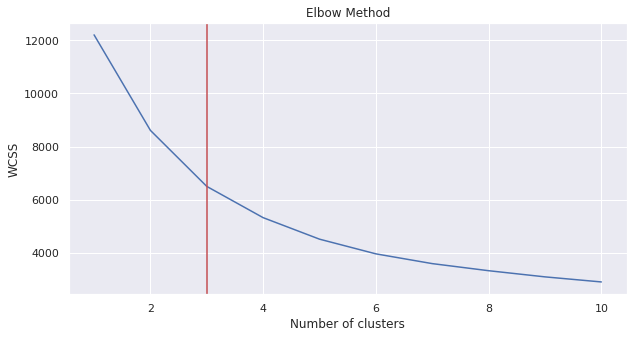

In [20]:
from sklearn.cluster import KMeans
plt.figure(figsize = (10,5))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_dataframe)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.axvline(3, color = "r")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
from sklearn import metrics
k_to_test = range(2,25,1) # [2,3,4, ..., 24]
silhouette_scores = []

for k in k_to_test:
    model_kmeans_k = KMeans( n_clusters = k )
    model_kmeans_k.fit(scaled_dataframe)
    labels_k = model_kmeans_k.labels_
    score_k = metrics.silhouette_score(scaled_dataframe, labels_k)
    silhouette_scores.append(score_k)
    print("Tested kMeans with k = %d\tSS: %5.4f" % (k, score_k))
    
print("Done!")

Tested kMeans with k = 2	SS: 0.2769
Tested kMeans with k = 3	SS: 0.3099
Tested kMeans with k = 4	SS: 0.2943
Tested kMeans with k = 5	SS: 0.3002
Tested kMeans with k = 6	SS: 0.2818
Tested kMeans with k = 7	SS: 0.2759
Tested kMeans with k = 8	SS: 0.2771
Tested kMeans with k = 9	SS: 0.2783
Tested kMeans with k = 10	SS: 0.2789
Tested kMeans with k = 11	SS: 0.2696
Tested kMeans with k = 12	SS: 0.2678
Tested kMeans with k = 13	SS: 0.2637
Tested kMeans with k = 14	SS: 0.2596
Tested kMeans with k = 15	SS: 0.2689
Tested kMeans with k = 16	SS: 0.2684
Tested kMeans with k = 17	SS: 0.2621
Tested kMeans with k = 18	SS: 0.2429
Tested kMeans with k = 19	SS: 0.2509
Tested kMeans with k = 20	SS: 0.2461
Tested kMeans with k = 21	SS: 0.2443
Tested kMeans with k = 22	SS: 0.2404
Tested kMeans with k = 23	SS: 0.2488
Tested kMeans with k = 24	SS: 0.2419
Done!


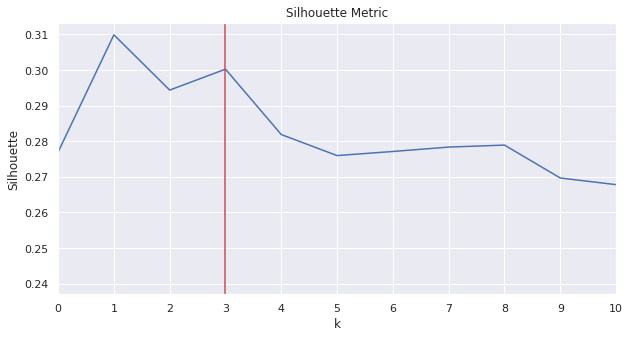

In [22]:
plt.figure(figsize = (10,5))
plt.plot(np.array(silhouette_scores))
plt.xticks(range(0,23,1))
plt.title("Silhouette Metric")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.axvline(3, color = "r")
plt.xlim(0,10)
plt.show()

In [23]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(scaled_dataframe)
features['cluster'] = kmeans.labels_

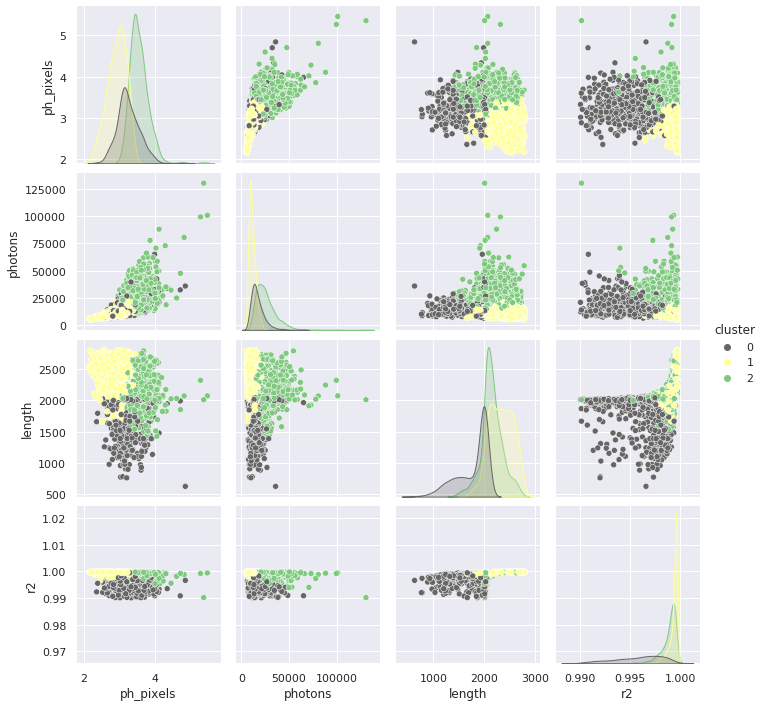

In [24]:
customPalette = sns.set_palette(sns.color_palette(['#0000FF', '#FF0000', '#00FF00']))
sns.pairplot(data = features, hue = "cluster", palette = "Accent_r")
plt.show()

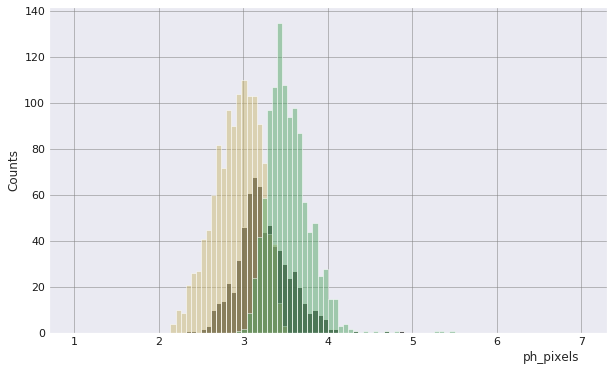

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.ph_pixels[features.cluster==0], bins=100, color='k', alpha=0.8, range=(1, 7))
plt.hist(features.ph_pixels[features.cluster==1], bins=100, color='y', alpha=0.5, range=(1, 7))
plt.hist(features.ph_pixels[features.cluster==2], bins=100, color='g', alpha=0.5, range=(1, 7))
#plt.yscale('Log')
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('ph_pixels', x=0.9)
plt.ylabel('Counts')
plt.show()

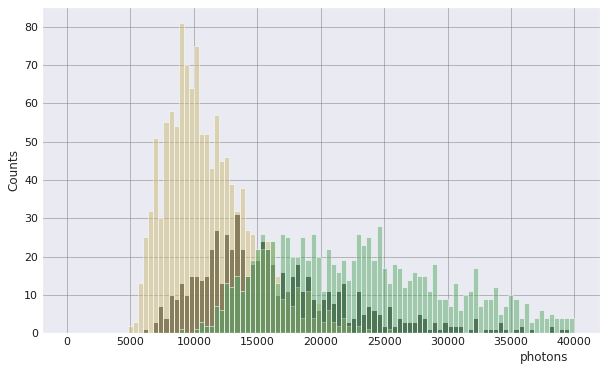

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.photons[features.cluster==0], bins=100, color='k', alpha=0.8, range=(0, 40000))
plt.hist(features.photons[features.cluster==1], bins=100, color='y', alpha=0.5, range=(0, 40000))
plt.hist(features.photons[features.cluster==2], bins=100, color='g', alpha=0.5, range=(0, 40000))
#plt.yscale('Log')
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('photons', x=0.9)
plt.ylabel('Counts')
plt.show()

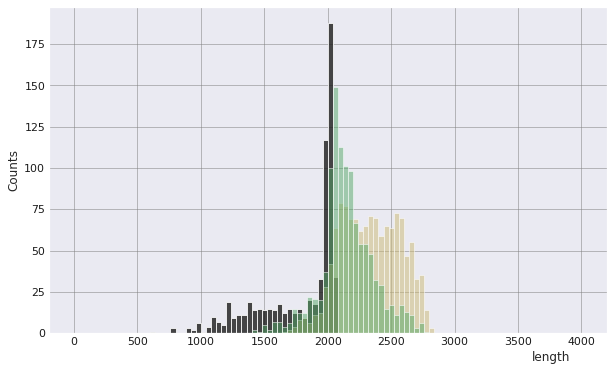

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.length[features.cluster==0], bins=100, color='k', alpha=0.8, range=(0, 4000))
plt.hist(features.length[features.cluster==1], bins=100, color='y', alpha=0.5, range=(0, 4000))
plt.hist(features.length[features.cluster==2], bins=100, color='g', alpha=0.5, range=(0, 4000))
#plt.yscale('Log')
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('length', x=0.9)
plt.ylabel('Counts')
plt.show()

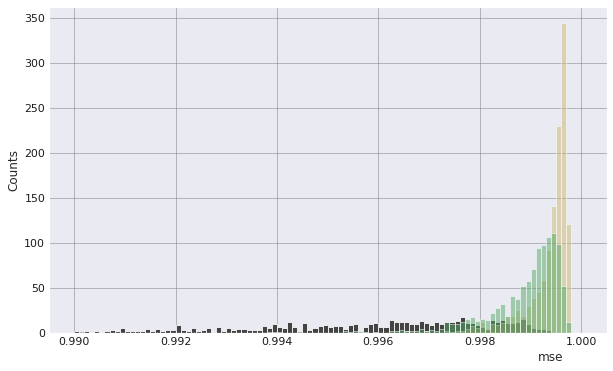

In [28]:
fig, ax = plt.subplots(figsize=(10,6))
from mpl_toolkits.mplot3d import Axes3D

plt.hist(features.r2[features.cluster==0], bins=100, color='k', alpha=0.8, range=(0.99, 1))
plt.hist(features.r2[features.cluster==1], bins=100, color='y', alpha=0.5, range=(0.99, 1))
plt.hist(features.r2[features.cluster==2], bins=100, color='g', alpha=0.5, range=(0.99, 1))
#plt.yscale('Log')00
plt.tick_params(axis="both", direction='in', which="both", length=6, width=1, colors='k',
                      grid_color='grey', grid_alpha=0.5)
plt.xlabel('mse', x=0.9)
plt.ylabel('Counts')
plt.show()

In [29]:

len(features[features.cluster==2])

1112

In [30]:
dataRun = run_info_logbook(int(fileInfo.cosmics[0].split('run')[-1]), verbose=True)


File_Number                                        4045
saved_events                                        200
Exposure_Time_ms                                      1
comments                          55Fe - Z = 36-1=35 cm
Nominal_Flux_He_CF4                               60/40
He_CF4                                              NaN
Transfer_field_kV_cm                                2.5
GEM3_V                                              430
GEM2_V                                              440
GEM1_V                                              440
Calculated_GEM_stack_V                             1315
Requested_Drift_field_V_cm                          960
Calculated_Field_Cage_Anode_V                     316.8
Real_Field_Cage_Anode_V                             317
Calculated_Field_Cage_Catode_V                    49632
Calculated_Drift_Field_V_cm                     960.004
Name: 2967, dtype: object


In [31]:
int(dataRun['saved_events'])*float(dataRun['Exposure_Time_ms'])*1e-3

0.2

In [32]:
len(features[features.cluster==2])/(int(dataRun['saved_events'])*float(dataRun['Exposure_Time_ms'])*1e-3)

5560.0